In [1]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))


True
Tesla T4


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
batch_size = 256
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

test_dataset = datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2
)


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.04MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.26MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 14.0MB/s]


In [4]:
class CNNVAE(nn.Module):
    def __init__(self, latent_dim=20):
        super(CNNVAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, stride=2, padding=1),  # 28x28 -> 14x14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1), # 14x14 -> 7x7
            nn.ReLU()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 64 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), # 7x7 -> 14x14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, stride=2, padding=1)   # 14x14 -> 28x28
        )

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_dec(z)
        h = h.view(-1, 64, 7, 7)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar


In [5]:
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy_with_logits(
        recon_x, x, reduction='sum'
    )
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD


In [6]:
device = torch.device("cuda")
model = CNNVAE(latent_dim=20).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [7]:
epochs = 15

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for data, _ in train_loader:
        data = data.to(device)

        optimizer.zero_grad()
        recon, mu, logvar = model(data)
        loss = vae_loss(recon, data, mu, logvar)

        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{epochs}] Loss: {total_loss / len(train_loader.dataset):.4f}")


Epoch [1/15] Loss: 176.1288
Epoch [2/15] Loss: 119.5932
Epoch [3/15] Loss: 113.5244
Epoch [4/15] Loss: 110.5462
Epoch [5/15] Loss: 108.5796
Epoch [6/15] Loss: 107.2798
Epoch [7/15] Loss: 106.2688
Epoch [8/15] Loss: 105.5478
Epoch [9/15] Loss: 104.9869
Epoch [10/15] Loss: 104.4878
Epoch [11/15] Loss: 104.0351
Epoch [12/15] Loss: 103.6684
Epoch [13/15] Loss: 103.3325
Epoch [14/15] Loss: 102.9906
Epoch [15/15] Loss: 102.7360


In [8]:
recon = torch.sigmoid(recon)


In [9]:
model.eval()


CNNVAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (fc_mu): Linear(in_features=3136, out_features=20, bias=True)
  (fc_logvar): Linear(in_features=3136, out_features=20, bias=True)
  (fc_dec): Linear(in_features=20, out_features=3136, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
)

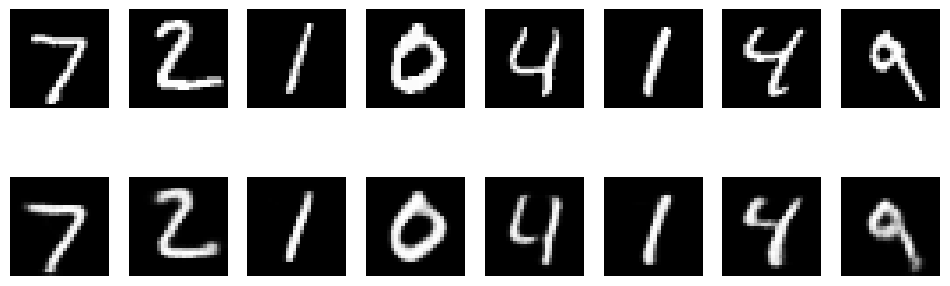

In [10]:
import matplotlib.pyplot as plt

with torch.no_grad():
    data, _ = next(iter(test_loader))
    data = data.to(device)
    recon, _, _ = model(data)
    recon = torch.sigmoid(recon)   # important

plt.figure(figsize=(12,4))
for i in range(8):
    # original
    plt.subplot(2, 8, i+1)
    plt.imshow(data[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

    # reconstructed
    plt.subplot(2, 8, i+9)
    plt.imshow(recon[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.show()


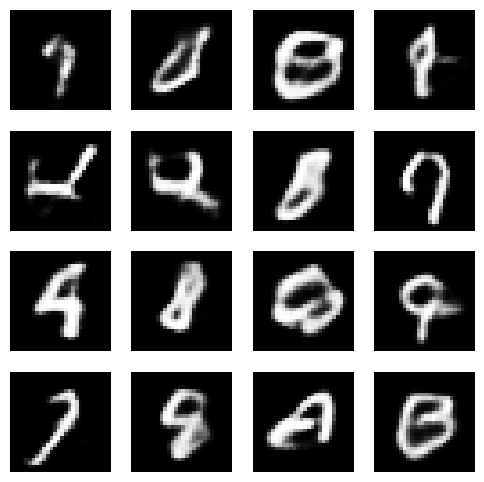

In [11]:
with torch.no_grad():
    z = torch.randn(16, 20).to(device)   # latent_dim = 20
    samples = model.decode(z)
    samples = torch.sigmoid(samples)

plt.figure(figsize=(6,6))
for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(samples[i].cpu().squeeze(), cmap="gray")
    plt.axis("off")

plt.show()
